In [13]:
import torch 
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
d = 'cuda' 

In [14]:
words = open('names.txt', 'r').read().split()

In [15]:

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [16]:
def build_dataset(words):

    X,Y = [],[]
    block_size = 8
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]

            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    
    X = torch.tensor(X, device=d)
    Y = torch.tensor(Y, device=d)
    print(X.shape, Y.shape)
    return X,Y

In [17]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
xtr,ytr = build_dataset(words[:n1])
xdev,ydev = build_dataset(words[n1:n2])
xte,yte = build_dataset(words[n2:])

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [18]:

class Linear:

    def __init__(self, fan_in, fan_out, bias=False):
        self.weight = torch.randn((fan_in, fan_out), device=d) / fan_in **0.5
        self.bias = torch.randn(fan_out, device=d) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
#-------------------------------------------------------------------

class Embedding:

    def __init__(self, num_emb, emb_dim):
        self.weight = torch.randn((num_emb, emb_dim),device=d)

    def __call__(self,x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

#-------------------------------------------------------------------

class BatchNorm:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable params
        self.gamma = torch.ones(dim, device=d)
        self.beta = torch.zeros(dim, device=d)
        # buffers: updated while running
        self.running_mean = torch.zeros(dim, device=d)
        self.running_var = torch.ones(dim, device=d)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / (xvar+self.eps) ** 0.5
        self.out = self.gamma * xhat + self.beta
       
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]



#-------------------------------------------------------------------
class Tanh:
    def __call__(self,x):
        self.out =  torch.tanh(x)
        return self.out

    def parameters(self):
        return []

#-------------------------------------------------------------------
class Sequential:

    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get paramters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

    def train(self, mode=True):
        for layer in self.layers:
            if hasattr(layer, 'train'):
                layer.train(mode)

In [19]:
class GRU:

    def __init__(self, _in, h_d, num_layers=3, bnorm=True):
        self.num_layers = num_layers
        self.h_d = h_d
        self.use_bn = bnorm
        self.params = {}

        for gate in ['z', 'r', 'h']:
            self.params[f'w{gate}'] = []
            self.params[f'u{gate}'] = []
            self.params[f'b{gate}'] = []

        if self.use_bn:
            self.bnorms = { 
                "bn_r": [],
                "bn_z": [],
                "bn_h": []
        }

        for layer in range(self.num_layers):
            input_dim = _in if layer == 0 else h_d

             # Gates
            for gate in ['z', 'r', 'h']:
                self.params[f"w{gate}"].append(torch.randn(input_dim, h_d, device=d) / math.sqrt(input_dim))
                self.params[f"u{gate}"].append(torch.randn(h_d, h_d, device=d) / math.sqrt(h_d))
                self.params[f"b{gate}"].append(torch.zeros(h_d, device=d))
        
            # BatchNorms
            if self.use_bn:
                self.bnorms["bn_r"].append(BatchNorm(h_d))
                self.bnorms["bn_z"].append(BatchNorm(h_d))
                self.bnorms["bn_h"].append(BatchNorm(h_d))


    def __call__(self,x, return_seq=False):
        B,seq = x.shape[0],x.shape[1]

        for layer in range(self.num_layers):
            h = torch.zeros(B, self.h_d, device=d)
            current_layer_outputs = []

            for t in range(seq):
                xt = x[:, t, :]
                    
                wz, uz, bz = self.params['wz'][layer], self.params['uz'][layer], self.params['bz'][layer]
                wr, ur, br = self.params['wr'][layer], self.params['ur'][layer], self.params['br'][layer]
                wh, uh, bh = self.params['wh'][layer], self.params['uh'][layer], self.params['bh'][layer]           
                xz = xt @ wz
                xr = xt @ wr
                xh = xt @ wh

                if self.use_bn:
                    xz = self.bnorms["bn_z"][layer](xz)
                    xr = self.bnorms["bn_r"][layer](xr)
                    xh = self.bnorms["bn_h"][layer](xh)

                rt = torch.sigmoid(xr + h @ ur + br)  # reset gate
                zt = torch.sigmoid(xz + h @ uz + bz)  # updated gate
                h_tilde = torch.tanh(xh + (h * rt) @ uh + bh)
                h = (1-zt) * h + zt * h_tilde
                current_layer_outputs.append(h)  
            
            x = torch.stack(current_layer_outputs, dim=1)

        self.out = x if return_seq else x[:, -1, :]
        return self.out


    def train(self, mode=True):
        if self.use_bn:
            for name in self.bnorms:
                for bn in self.bnorms[name]:
                    bn.training = mode


    def parameters(self):
        params = []
        
        # Add GRU weights and biases
        for key in self.params:
            for p in self.params[key]:
                params.append(p)
        
        # Add BatchNorm parameters if used
        if self.use_bn:
            for key in self.bnorms:
                for bn in self.bnorms[key]:
                    params.extend(bn.parameters())  # each bn.parameters() is a list

        return params


In [20]:
emb_dim = 32
hidden_state = 128

# model = Sequential([
#     Embedding(vocab_size, emb_dim),
#     GRU(emb_dim, hidden_state),
#     Linear(hidden_state, 27)
# ])

model = Sequential([
    Embedding(vocab_size, emb_dim),
    GRU(emb_dim, hidden_state),
    Linear(hidden_state, hidden_state),  # Extra projection layer
    Tanh(),
    Linear(hidden_state, vocab_size),
])

parameters = model.parameters()

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

lossi = []

282208


In [21]:
ix = torch.randint(0, xtr.shape[0], (4,)) 
Xb,Yb = xtr[ix], ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 14,  1, 11,  8],
        [ 0,  0,  0,  0,  0,  0, 11,  5],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0,  1, 12]], device='cuda:0')

In [22]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 32)
GRU : (4, 128)
Linear : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [23]:
model.train(False)


In [65]:
steps = 5000
batch_size = 32

for i in range(steps):

    ix = torch.randint(0, xtr.shape[0],(batch_size, ), device=d)
    xb, yb = xtr[ix], ytr[ix]

    # forward pass
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.0001

    for p in parameters:
        p.data -= p.grad * lr

    if i % 200 == 0:  # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

      0/   5000: 2.438370
    200/   5000: 2.088076
    400/   5000: 1.772020
    600/   5000: 2.054077
    800/   5000: 2.173436
   1000/   5000: 2.261066
   1200/   5000: 2.294366
   1400/   5000: 1.991923
   1600/   5000: 2.374691
   1800/   5000: 2.020822
   2000/   5000: 2.215531
   2200/   5000: 1.826537
   2400/   5000: 2.146207
   2600/   5000: 2.129124
   2800/   5000: 2.492601
   3000/   5000: 2.709848
   3200/   5000: 1.912327
   3400/   5000: 2.077540
   3600/   5000: 2.422579
   3800/   5000: 2.354076
   4000/   5000: 2.452008
   4200/   5000: 2.277665
   4400/   5000: 1.989995
   4600/   5000: 2.431522
   4800/   5000: 2.212845


In [66]:
len(lossi)

40000

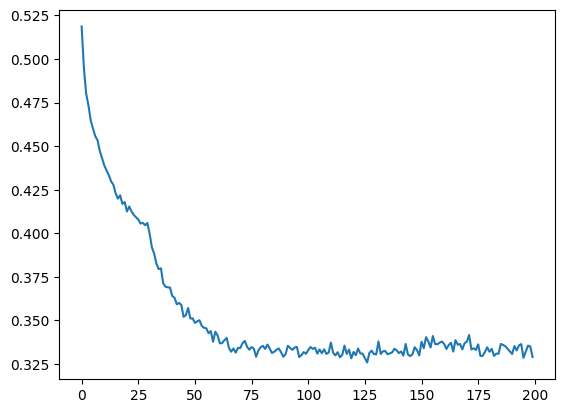

In [67]:
plt.plot(torch.tensor(lossi).view(-1,200).mean(1));

In [70]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (xtr,ytr),
        'val' : (xdev, ydev),
        'test' : (xte, xte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.3220717906951904
val 2.566006660461426


In [69]:
model.train(False)


In [78]:
block_size = 8


for _ in range(20):

    out = []
    context = [0] * block_size  # initialise with all..
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context], device=d))
        probs = F.softmax(logits, dim=1) ** 1.65
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

lonlay.
rayan.
einis.
jesynne.
elon.
eilion.
eaileyn.
lousah.
caleist.
yesiia.
oeany.
meliyan.
etlianr.
saylian.
eayly.
alynn.
aliny.
emrah.
maislan.
eollira.
